# [Quantization Aware Training](https://www.tensorflow.org/model_optimization/guide/quantization/training)

Implementing quantisation aware training technique on RPS Dataset.


Author: [Sayan Nath](http://github.com/sayannath)<br>
Last Updated: 2021/03/29
<br>
<br>
<a href="https://colab.research.google.com/drive/1Wdso2N_76E8Xxniqd4C6T1sV5BuhKN1o?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intital Setup

In [1]:
!nvidia-smi

Mon Mar 29 12:09:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip uninstall -y tensorflow
!pip install -q tf-nightly
!pip install -qq tensorflow-model-optimization

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 454.3MB 38kB/s 
     |████████████████████████████████| 1.2MB 48.0MB/s 
     |████████████████████████████████| 6.0MB 47.4MB/s 
     |████████████████████████████████| 4.0MB 42.9MB/s 
     |████████████████████████████████| 471kB 53.8MB/s 
     |████████████████████████████████| 4.0MB 51.4MB/s 
     |████████████████████████████████| 3.9MB 54.0MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
     |████████████████████████████████| 174kB 16.8MB/s 


## Data Gathering

In [3]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip 
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip

--2021-03-29 12:12:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 142.250.73.240, 172.217.8.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M   145MB/s    in 1.3s    

2021-03-29 12:12:15 (145 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2021-03-29 12:12:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.217.2.112, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.

In [4]:
!unzip -q rps.zip
!unzip -qq rps-test-set.zip

## Import necessary modules

In [5]:
from imutils import paths
from pprint import pprint
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
import tensorflow_model_optimization as tfmot
import re 

import os
from sys import getsizeof
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import accuracy_score
from sys import getsizeof

import numpy as np
np.random.seed(42)


print(tf.__version__)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
2.6.0-dev20210329


In [6]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size/1024, 3)) + 'Kilobytes')
    elif unit == 'MB':
        return print('File Size: ' + str(round(size/(1024*1024), 3)) + 'Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

## Determine the dimension of the images

In [7]:
train_dir='rps/'
test_dir='rps-test-set/'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Height:  300.0
Width:  300.0


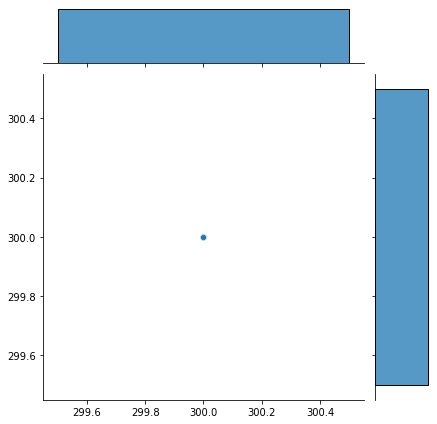

In [8]:
dim1 = []
dim2 = []
for image_filename in os.listdir(train_dir+'paper'):
    
    img = mpimg.imread(train_dir+'paper'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

sns.jointplot(dim1,dim2)

print("Height: ",np.mean(dim1))
print("Width: ",np.mean(dim2))

`Height` is 300 and `Width` is 300

In [9]:
image_paths = list(paths.list_images("rps"))
np.random.shuffle(image_paths)
image_paths[:5]

['rps/rock/rock04-115.png',
 'rps/scissors/scissors04-068.png',
 'rps/scissors/scissors04-047.png',
 'rps/rock/rock07-k03-044.png',
 'rps/paper/paper07-117.png']

## Couting the number of Images per classes

In [10]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'rock': 840, 'scissors': 840, 'paper': 840})


Wow! Balanced Dataset

## Define the Hyperparameters

In [11]:
BATCH_SIZE = 128
EPOCHS = 20
IMG_SIZE = 150
NUM_CLASSES=3

In [12]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')


validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(IMG_SIZE,IMG_SIZE),
	class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_directory(
	test_dir,
	target_size=(IMG_SIZE,IMG_SIZE),
	class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [13]:
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

## Define the Model

In [14]:
def training_model():
    model = Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')                       
    ])
    return model

## Summary of the Model

In [15]:
model = training_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Compile and Train the Baseline Model

In [16]:
#Compile the Model
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#Train the Model
history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=20, validation_data = validation_generator, validation_steps=3, batch_size=BATCH_SIZE)

Epoch 1/20
20/20 [==============================] - 153s 8s/step - loss: 1.6691 - accuracy: 0.3288 - val_loss: 1.0963 - val_accuracy: 0.3333
Epoch 2/20
20/20 [==============================] - 150s 7s/step - loss: 1.1090 - accuracy: 0.3786 - val_loss: 1.0841 - val_accuracy: 0.3925
Epoch 3/20
20/20 [==============================] - 151s 8s/step - loss: 1.0853 - accuracy: 0.3995 - val_loss: 1.0907 - val_accuracy: 0.3360
Epoch 4/20
20/20 [==============================] - 153s 8s/step - loss: 1.0781 - accuracy: 0.4319 - val_loss: 1.0076 - val_accuracy: 0.4919
Epoch 5/20
20/20 [==============================] - 152s 8s/step - loss: 1.0135 - accuracy: 0.4760 - val_loss: 0.9914 - val_accuracy: 0.6855
Epoch 6/20
20/20 [==============================] - 152s 8s/step - loss: 0.9675 - accuracy: 0.5599 - val_loss: 0.7068 - val_accuracy: 0.7527
Epoch 7/20
20/20 [==============================] - 153s 8s/step - loss: 0.8461 - accuracy: 0.5912 - val_loss: 0.6123 - val_accuracy: 0.7231
Epoch 8/20
20

## Evaluate our Baseline Model

In [17]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=1)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

3/3 [==============================] - 6s 2s/step - loss: 0.3334 - accuracy: 0.8575
Test Accuracy: 0.8575268983840942
Test Loss: 0.3334425091743469


## Plot the Acc and Loss Curve

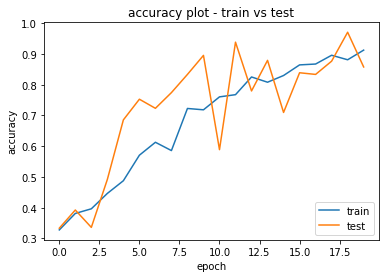

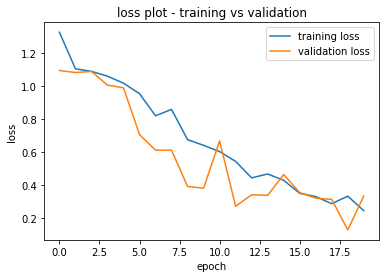

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('accuracy plot - train vs test')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs validation')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

## Saving our Baseline Model

In [19]:
model.save('rps_model')
model.save('rps.h5')

INFO:tensorflow:Assets written to: rps_model/assets


In [20]:
!du -lh rps_model

27M	rps_model/variables
4.0K	rps_model/assets
27M	rps_model


In [21]:
convert_bytes(get_file_size('rps.h5'), "MB")

File Size: 26.557Megabytes


In [22]:
!tar cvf rps.tar.gz rps_model rps.h5

rps_model/
rps_model/keras_metadata.pb
rps_model/saved_model.pb
rps_model/variables/
rps_model/variables/variables.index
rps_model/variables/variables.data-00000-of-00001
rps_model/assets/
rps.h5


## Quantising our Model

In [23]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 150, 150, 3)       3         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 148, 148, 64)      1923      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 74, 74, 64)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 72, 72, 64)        37059     
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 36, 36, 64)        1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 34, 34, 128)       74115     
_________________________________________________________________
quant_max_pooling2d_2 (Quant (None, 17, 17, 128)       1

## Train the Quantise Model

In [24]:
q_aware_model.fit(train_generator, epochs=20, validation_data = validation_generator, batch_size=256)

Epoch 1/20
20/20 [==============================] - 177s 9s/step - loss: 0.9902 - accuracy: 0.7936 - val_loss: 0.1707 - val_accuracy: 0.8978
Epoch 2/20
20/20 [==============================] - 177s 9s/step - loss: 0.4041 - accuracy: 0.8493 - val_loss: 0.1008 - val_accuracy: 0.9704
Epoch 3/20
20/20 [==============================] - 175s 9s/step - loss: 0.2003 - accuracy: 0.9246 - val_loss: 0.2222 - val_accuracy: 0.8978
Epoch 4/20
20/20 [==============================] - 173s 9s/step - loss: 0.1648 - accuracy: 0.9408 - val_loss: 0.4998 - val_accuracy: 0.7581
Epoch 5/20
20/20 [==============================] - 171s 9s/step - loss: 0.3253 - accuracy: 0.8878 - val_loss: 0.0466 - val_accuracy: 0.9812
Epoch 6/20
20/20 [==============================] - 173s 9s/step - loss: 0.1835 - accuracy: 0.9324 - val_loss: 0.0570 - val_accuracy: 0.9758
Epoch 7/20
20/20 [==============================] - 172s 9s/step - loss: 0.1908 - accuracy: 0.9304 - val_loss: 0.2010 - val_accuracy: 0.9140
Epoch 8/20
20

## Evaluate the Quantise Model

In [25]:
q_aware_model_loss, q_aware_model_accuracy = q_aware_model.evaluate(validation_generator, verbose=1)
print('Quant Test Accuracy:', q_aware_model_accuracy)
print('Quant Test Loss:', q_aware_model_loss)

3/3 [==============================] - 7s 2s/step - loss: 0.0561 - accuracy: 0.9785
Quant Test Accuracy: 0.9784946441650391
Quant Test Loss: 0.05613008141517639


## Convert the Baseline Model to TF-Lite

In [27]:
TF_LITE_MODEL_FILE_NAME = 'tf_lite_model_rps.tflite'

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpagum708k/assets


INFO:tensorflow:Assets written to: /tmp/tmpagum708k/assets


13898360

## Convert the Quantise Model to TF-Lite

In [39]:
TF_LITE_QUANT_MODEL_FILE_NAME = 'tf_lite_quant_model_rps.tflite'

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpi7qy6wk8/assets


INFO:tensorflow:Assets written to: /tmp/tmpi7qy6wk8/assets


3491848

## Calculating the file size

In [29]:
convert_bytes(get_file_size('tf_lite_model_rps.tflite'), "MB")
convert_bytes(get_file_size('tf_lite_quant_model_rps.tflite'), "MB")

File Size: 13.255Megabytes
File Size: 3.33Megabytes


In [32]:
images, labels = (next(iter(validation_generator)))

In [33]:
print(images.shape)
print(images.dtype)

(128, 150, 150, 3)
float32


## Check the Tensors Shape - Baseline Model

In [36]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 150 150   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 3]
Output Type: <class 'numpy.float32'>


## Resize the Tensor Shape - Baseline Model

In [37]:
interpreter.resize_tensor_input(input_details[0]['index'], (128, 150, 150, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (128, 3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [128 150 150   3]
Input Type: <class 'numpy.float32'>
Output Shape: [128   3]
Output Type: <class 'numpy.float32'>


## Making Predictions on Baseline TF-Lite Model

In [38]:
interpreter.set_tensor(input_details[0]['index'], images)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)
expected_classes = np.argmax(labels, axis=1)

acc = accuracy_score(prediction_classes, expected_classes)
print('Test accuracy TFLITE model :', acc)

Prediction results shape: (128, 3)
Test accuracy TFLITE model : 0.8125


## Check the Tensors Shape - Quantise Model

In [31]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 150 150   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 3]
Output Type: <class 'numpy.float32'>


## Resize the Tensor Shape - Quantise Model

In [34]:
interpreter.resize_tensor_input(input_details[0]['index'], (128, 150, 150, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (128, 3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [128 150 150   3]
Input Type: <class 'numpy.float32'>
Output Shape: [128   3]
Output Type: <class 'numpy.float32'>


## Making Predictions on Quantise TF-Lite Model

In [35]:
interpreter.set_tensor(input_details[0]['index'], images)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)
expected_classes = np.argmax(labels, axis=1)

acc = accuracy_score(prediction_classes, expected_classes)
print('Test accuracy TFLITE model :', acc)

Prediction results shape: (128, 3)
Test accuracy TFLITE model : 0.9609375


# Result Summary


| Configuration          | Baseline Model | Quantised Model |
|------------------------|----------------|-----------------|
| EPOCHS                 | 20             | 20              |
| Model Accuracy         | 85.75%         | 97.84%          |
| TF-Lite File Size      | 13.255 MB      | 3.33 MB         |
| TF-Lite Model Accuracy | 81.25%         | 96.09%          |